# Potter2Vec

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\Zeki\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zeki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zeki\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Metnin Hazırlanması

**Kitaplar klasörden okunur**

In [7]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['data\\book1.txt',
 'data\\book2.txt',
 'data\\book3.txt',
 'data\\book4.txt',
 'data\\book5.txt',
 'data\\book6.txt',
 'data\\book7.txt']

**Bütün kitaplar tek bir yerde birleştirilir**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\book1.txt'...
Corpus is now 489671 characters long

Reading 'data\book2.txt'...
Corpus is now 1038070 characters long

Reading 'data\book3.txt'...
Corpus is now 1519805 characters long

Reading 'data\book4.txt'...
Corpus is now 2744585 characters long

Reading 'data\book5.txt'...
Corpus is now 2993617 characters long

Reading 'data\book6.txt'...
Corpus is now 4085003 characters long

Reading 'data\book7.txt'...
Corpus is now 4792785 characters long



**NLTK Kütüphanesi ile anlama etkisi olmayan kelimeler temizlenir**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 807,537 tokens


## Word2Vec Oluşturulması ve Eğitilmesi

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
potter2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
potter2vec.build_vocab(sentences)

2018-01-02 16:59:38,507 : INFO : collecting all words and their counts
2018-01-02 16:59:38,511 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-02 16:59:38,559 : INFO : PROGRESS: at sentence #10000, processed 169399 words, keeping 10043 word types
2018-01-02 16:59:38,611 : INFO : PROGRESS: at sentence #20000, processed 341313 words, keeping 14582 word types
2018-01-02 16:59:38,671 : INFO : PROGRESS: at sentence #30000, processed 513759 words, keeping 17642 word types
2018-01-02 16:59:38,703 : INFO : PROGRESS: at sentence #40000, processed 710603 words, keeping 20602 word types
2018-01-02 16:59:38,737 : INFO : collected 21991 word types from a corpus of 807537 raw words and 45068 sentences
2018-01-02 16:59:38,737 : INFO : Loading a fresh vocabulary
2018-01-02 16:59:38,777 : INFO : min_count=3 retains 10956 unique words (49% of original 21991, drops 11035)
2018-01-02 16:59:38,781 : INFO : min_count=3 leaves 793426 word corpus (98% of original 807537, dro

In [19]:
print("Word2Vec vocabulary length:", len(potter2vec.wv.vocab))

Word2Vec vocabulary length: 10956


**Start training, this might take a minute or two...**

In [20]:
potter2vec.train(sentences,total_examples=potter2vec.corpus_count, epochs=potter2vec.iter)

2018-01-02 16:59:45,370 : INFO : training model with 4 workers on 10956 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-01-02 16:59:46,480 : INFO : PROGRESS: at 7.61% examples, 199814 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:47,491 : INFO : PROGRESS: at 14.34% examples, 199400 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:48,530 : INFO : PROGRESS: at 21.08% examples, 202381 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:49,550 : INFO : PROGRESS: at 29.12% examples, 208982 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:50,559 : INFO : PROGRESS: at 36.15% examples, 210271 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:51,580 : INFO : PROGRESS: at 43.45% examples, 211356 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:52,605 : INFO : PROGRESS: at 51.52% examples, 213681 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:53,656 : INFO : PROGRESS: at 58.23% examples, 212992 words/s, in_qsize 7, out_qsize 0
2018-01-02 16:59:54,665 : I

3029745

**Eğitilen modelin Kaydedilmesi**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
potter2vec.save(os.path.join("trained", "potter2vec.w2v"))

2018-01-02 17:00:11,558 : INFO : saving Word2Vec object under trained\potter2vec.w2v, separately None
2018-01-02 17:00:11,562 : INFO : not storing attribute syn0norm
2018-01-02 17:00:11,562 : INFO : not storing attribute cum_table
2018-01-02 17:00:11,903 : INFO : saved trained\potter2vec.w2v


## Kaydedilen Modelin Yüklenmesi.

In [23]:
potter2vec = w2v.Word2Vec.load(os.path.join("trained", "potter2vec.w2v"))

2018-01-02 17:00:19,798 : INFO : loading Word2Vec object from trained\potter2vec.w2v
2018-01-02 17:00:20,008 : INFO : loading wv recursively from trained\potter2vec.w2v.wv.* with mmap=None
2018-01-02 17:00:20,008 : INFO : setting ignored attribute syn0norm to None
2018-01-02 17:00:20,008 : INFO : setting ignored attribute cum_table to None
2018-01-02 17:00:20,017 : INFO : loaded trained\potter2vec.w2v


### TSNE ile Eğitilen Modelin Görselleştirilmesi

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = potter2vec.wv.syn0

**Metinde geçen kelimelerin tsne ile koordinatlarının belirlenmesi**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[potter2vec.wv.vocab[word].index])
            for word in potter2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,THE,4.471183,-4.804536
1,BOY,4.592094,-4.034098
2,WHO,4.497821,-4.610076
3,Mr,-2.756413,0.971352
4,and,6.673206,5.418769
5,Mrs,-2.547108,0.688342
6,Dursley,1.967758,-1.249715
7,of,4.078618,3.026075
8,number,-0.671735,-2.687693
9,four,-0.428128,-2.599975


In [29]:
sns.set_context("poster")

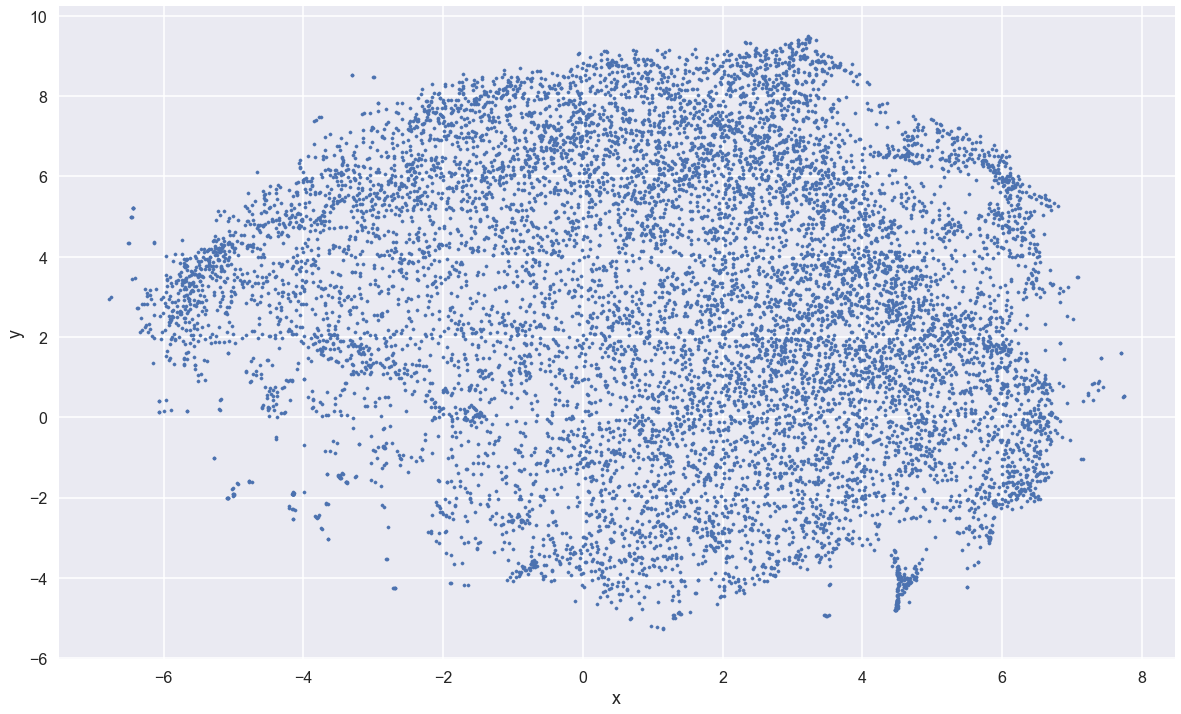

In [30]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [31]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

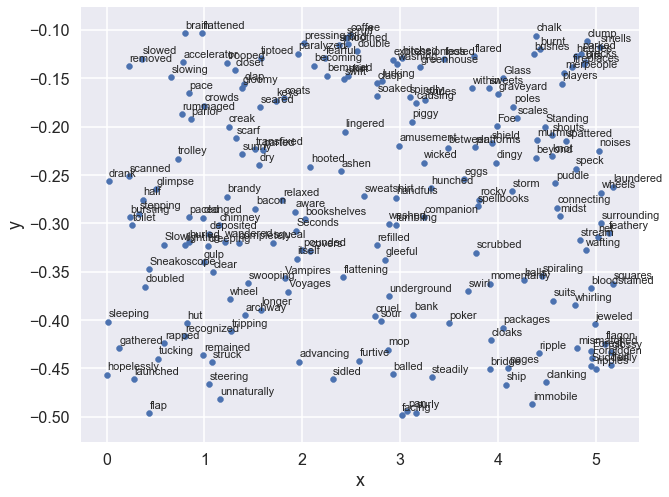

In [78]:
plot_region(x_bounds=(0.0, 5.2), y_bounds=(-0.5, -0.1))

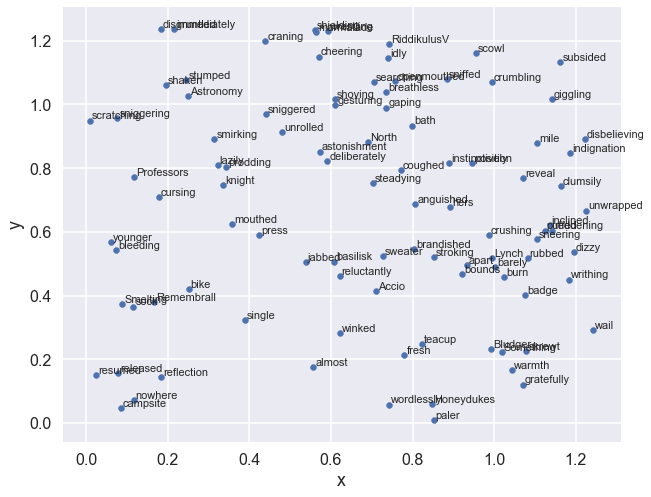

In [114]:
plot_region(x_bounds=(0, 1.25), y_bounds=(0, 1.25))

### Verilen kelimeler arasında anlamsal ilişkilerin keşfedilmesi

In [41]:
potter2vec.most_similar("Hogwarts")

[('school', 0.7983509302139282),
 ('King', 0.7463991045951843),
 ('security', 0.7340179085731506),
 ('Hog', 0.7310435175895691),
 ('arriving', 0.7306082248687744),
 ('Championship', 0.7301917672157288),
 ('Witchcraft', 0.7284759283065796),
 ('Cross', 0.7237019538879395),
 ('arrive', 0.7220003604888916),
 ('September', 0.7179888486862183)]

In [56]:
potter2vec.most_similar("Severus")

[('Minerva', 0.8662872314453125),
 ('calmly', 0.8521550297737122),
 ('Plank', 0.8489537239074707),
 ('Grubbly', 0.8476581573486328),
 ('Certainly', 0.8368253707885742),
 ('Alastor', 0.8354668617248535),
 ('kindly', 0.8284854888916016),
 ('curtly', 0.8186719417572021),
 ('Horace', 0.8167145252227783),
 ('trusting', 0.81410813331604)]

In [109]:
potter2vec.most_similar("Lee")

[('Jordan', 0.9495911598205566),
 ('twins', 0.8789891004562378),
 ('Angelina', 0.8724427223205566),
 ('Charlie', 0.8442481756210327),
 ('Johnson', 0.8095115423202515),
 ('Bell', 0.808600664138794),
 ('Alicia', 0.8070407509803772),
 ('Demelza', 0.7998273372650146),
 ('Pygmy', 0.7990003824234009),
 ('bracingly', 0.7959675192832947)]

In [52]:
potter2vec.most_similar("Quidditch")

[('match', 0.8261326551437378),
 ('Cup', 0.8209196329116821),
 ('team', 0.8146774768829346),
 ('World', 0.8098978400230408),
 ('Seeker', 0.778986930847168),
 ('Captain', 0.7646517753601074),
 ('game', 0.7579631209373474),
 ('played', 0.7455272674560547),
 ('practice', 0.7369740009307861),
 ('training', 0.7350970506668091)]

In [82]:
potter2vec.most_similar("Potter")

[('Goblet', 0.8208190202713013),
 ('Half', 0.8207808136940002),
 ('Philosophers', 0.8135073184967041),
 ('Deathly', 0.8133648633956909),
 ('Chamber', 0.8017414212226868),
 ('Fire', 0.7977768182754517),
 ('Blood', 0.7973983287811279),
 ('Secrets', 0.7956076860427856),
 ('Phoenix', 0.7952021360397339),
 ('Prisoner', 0.7921135425567627)]

**Kelime çiftleri arasındaki pozitif-negatif ilişkinin keşfedilmesi**

In [58]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = potter2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [103]:
nearest_similarity_cosmul("Severus", "Minerva", "Ron")
nearest_similarity_cosmul("Ron", "Potter", "Hermione")
nearest_similarity_cosmul("Dumbledore", "McGonagall", "Sirius")

Severus is related to Minerva, as Parvati is related to Ron
Ron is related to Potter, as Ginny is related to Hermione
Dumbledore is related to McGonagall, as Wormtail is related to Sirius


'Wormtail'